# Technical lag (debt) for Debian packages

Software is usually deployed as distribution packages. Those can be packages in a Linux-based distribution, apps in a mobile app market, or part of a virtual machine image. We will call "package" to the source code of the software being actually deployed, while we will call "upstream product" to the source code as it is produced by the original authors. Therefore, packages are always derived from a certain version (snahpshot) of the upstream product. In this study, we focus on Debian packages.

In many circumstances, the ideal situation would be having deployed packages perfectly updated, so that they correspond to the latest available upstream product. That would mean having more functionality, and more bugs fixed. However, usually packages lag from the current upstream product. Here, we propose some metrics to quantify that lag, and explore how they can be measured for Debian packages.

## Software

All the software and configuration for running this notebook can be found in the [jgbarah/techlag GitHub repository](http://github.com/jgbarah/techlag).

To produce the data, we use the following command:
    
```
$ time debsnapshotlag -c snapshot.json -l info --ratio 5 --range 5 --gitcache \
    --store debian-store/ --logfile debsnapshotlag-logging.log > debsnapshotlag-out.log
```

This command uses the file `snapshot.json` to define the families of Debian packages to retrieve from the [Debian Snapshot archive](http://snapshot.debian.org/), and the git repository corresponding to each of them. By "family of Debian packages", we refer to all the versions available in the archive for a certain package.

As a result, the command produces (in addition to the log files, which have some interesting informaiton) two shelve-managed files: `data-done.db` and `data-missing.db`. The first one has the data for the packages that could be computed, and the second one the list of packages which, for some reason, could not be computed.

To show the results, you only need to run the `showresults` program in the same directory where `data-done.db` is:

```
$ showresults > results.txt
```

The produced `results.txt` file includes information about the analysis results, and about the packages that couldn't be analyzed. For our analysis, the most interesting part are the lines starting with "CSV":

```
$ grep CSV results.txt > results.csv
```

The resulting file can be easily imported in a spreadsheet, or read with Python into a Pandas data frame, for example.

```
CSV,package,date,diff_commits,same_lines,right_files,added_lines,different_files,different_lines,same_files,removed_lines,common_files,common_lines,right_lines,left_files,normal_effort,diff_files,equal_lines,left_lines
CSV,acl:2.2.48-1,20090825T110258Z,81,5988,34,2314,117,3494,59,1993,59,13858,890,30,54,85,7870,1791
CSV,bash:3.2-4,20080513T000000Z,6,92091,85,147978,543,140697,642,105488,642,585202,27929,0,3,501,493111,0
...
```

The first line is a header, showing the name of the different parameters. Then, there is a line per package version, including a date for ordering the packages if needed. That date is the build date of the package (usually very close to its publication date), comming from the package description.


# Analysis of the results

Let's start by importing the needed packages, and set plotting output properly.

In [135]:
import pandas as pd
import dateutil.parser
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# Set ipython's max row display
pd.set_option('display.max_row', 10)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# Set mmaplotlib style to something nice
matplotlib.style.use('ggplot')

Now, let's read the csv file we obtained above, import it into a Panda dataframe, and show the frequency for each package name in it.

In [130]:
def splitter (package):
    """Split a Debian package name in its components
    
    :param package: full Debian package name
    :return:        pd.Series (name, version, epoch, upstream, revision)
    
    """

    name = package.split(':',1)[0]
    version = package.split(':',1)[1]
    if ':' in version:
        (epoch, rest) = version.split(':',1)
    else:
        (epoch, rest) = ('', version)
    if '-' in rest:
        (upstream, revision) = rest.rsplit('-',1)
    else:
        (upstream, revision) = (rest, '')
    return pd.Series({'name': name, 'version': version, 'epoch': epoch,
                     'upstream': upstream, 'revision': revision})

# Columnos of interst in the CSV to read
parameters = ['different_lines', 'common_lines', 'different_files', 'common_files',
              'diff_commits', 'normal_effort']
# Read results (all lines start with "CSV")
df = pd.read_csv("results/results.csv")

# Convert dates to datetime
df['datetime'] = df['date'].apply(dateutil.parser.parse)
# Add fields for the components of the Debian package name
# For each package we will have now
# ['package', 'name', 'version', 'epoch', 'upstream', 'revision']
df = df.merge(df['package'].apply(splitter), left_index=True, right_index=True)

# Names of packages in dataframe
pkg_names = df['name'].unique()
# Number of versions (all packages)
pkg_count = len(df.index)
# Number of versions (for each package)
pkg_name_counts = df['name'].value_counts()

print('Analyzing a total of {} package versions'.format(pkg_no))
print('Package names:', ', '.join(pkg_names))
print('Parameters available:', ', '.join(list(df)))
print('Parameters to analyze:', ', '.join(parameters))
print('Versions for each package:')
for (name, count) in pkg_name_counts.items():
    print('    {}: {}'.format(name, count))

Analyzing a total of 449 package versions
Package names: acl, bash, git, openssl, bluez, docker-compose
Parameters available: CSV, package, date, diff_commits, same_lines, right_files, added_lines, different_files, different_lines, same_files, removed_lines, common_files, common_lines, right_lines, left_files, normal_effort, diff_files, equal_lines, left_lines, datetime, epoch, name, revision, upstream, version
Parameters to analyze: different_lines, common_lines, different_files, common_files, diff_commits, normal_effort
Versions for each package:
    git: 192
    openssl: 87
    bash: 78
    bluez: 64
    acl: 24
    docker-compose: 4


Now, let's create a dictionary of dataframes (pkgs). Keys in this dictionary are package names, and dataframes include all the rows we need as parameters.

In [131]:
pkgs = {}
for name in pkg_names:
#for name in ['acl']:
    pkgs[name] = df[df['name'] == name]
    pkgs[name] = pkgs[name].sort_values(by=['epoch', 'upstream', 'revision'])

## Parameters over time

Next charts show some of the relevant parameters for each package, plotting them according to the package date. Some of the spikes and strange ups and downs are due to "old" versions of the packages being maintained (maintenance releases of "old" packages).

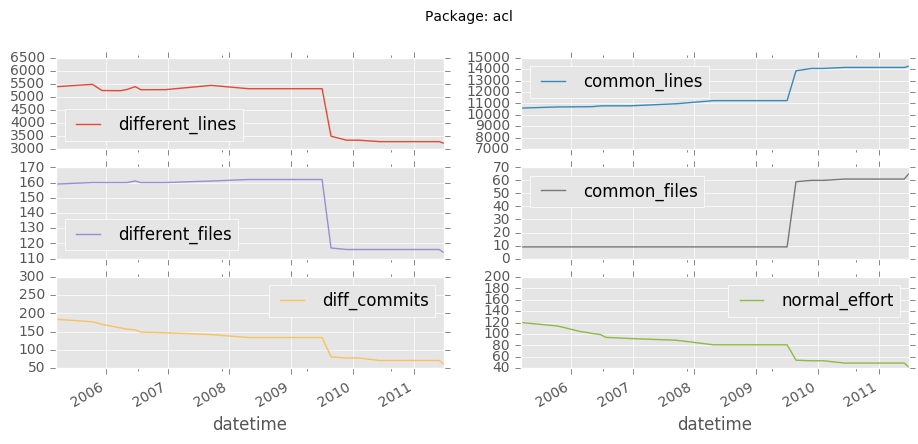

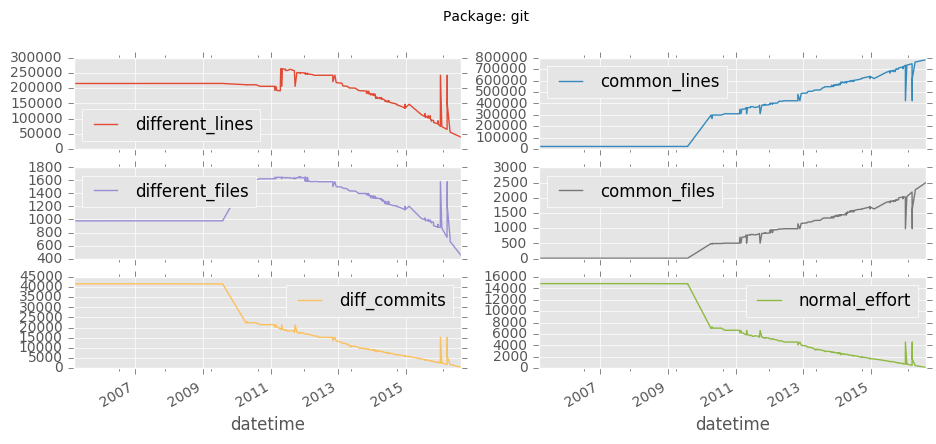

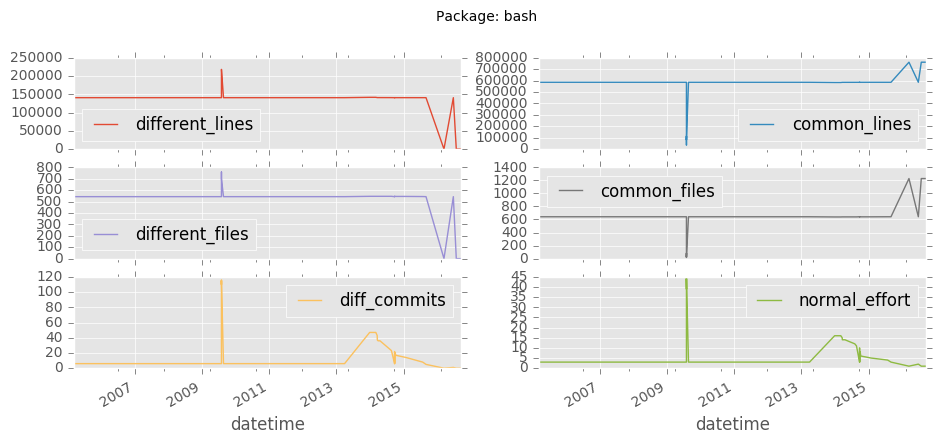

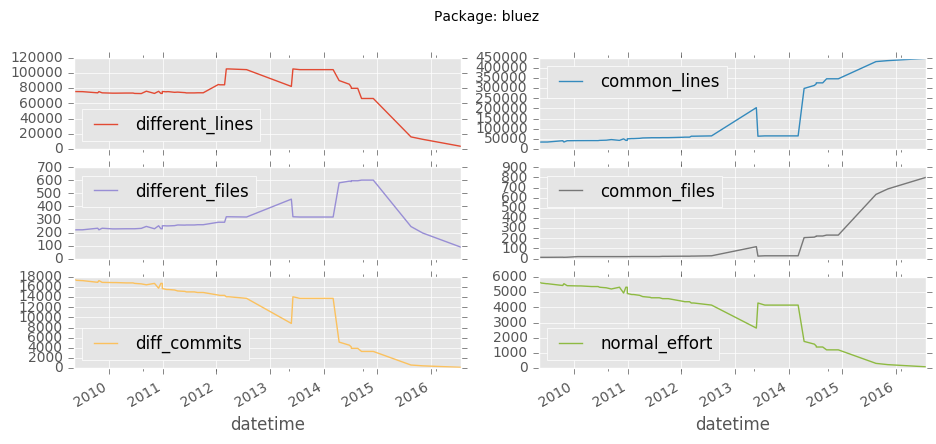

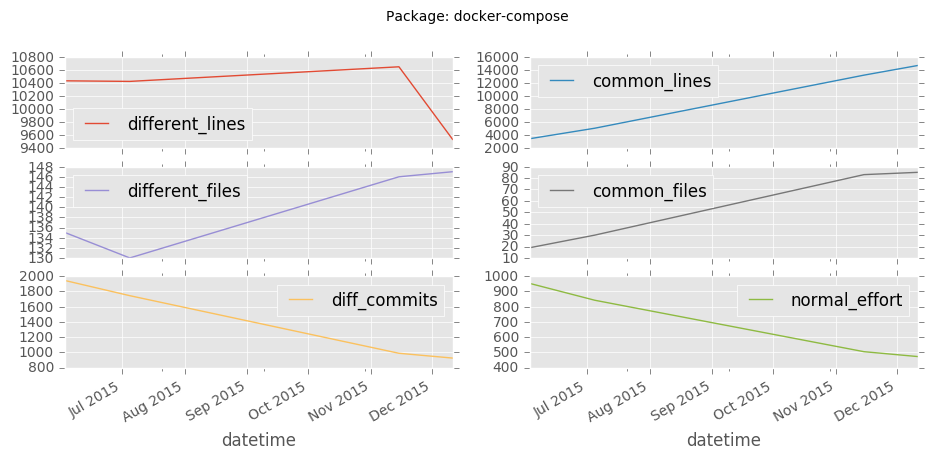

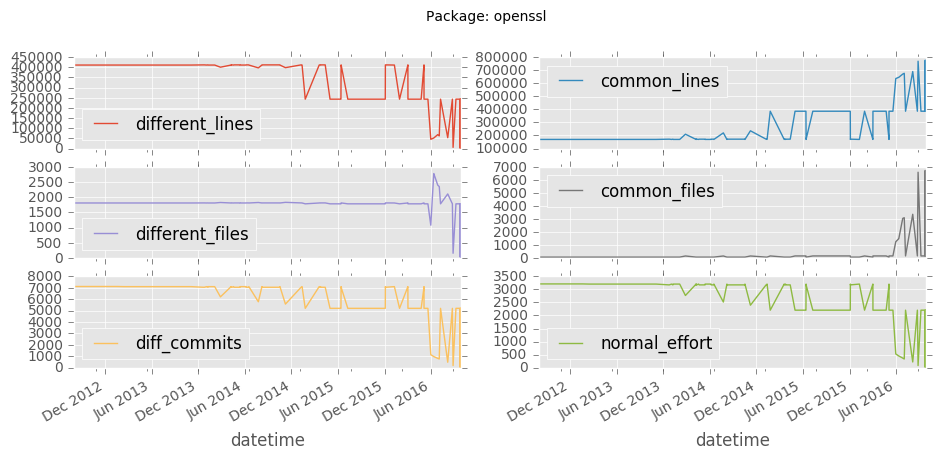

In [132]:
for name in pkgs:
    df_plot = pkgs[name][['datetime'] + parameters]
    plt.figure()
    ax = df_plot.plot(x='datetime', subplots=True, grid=True, layout=(4,2), sharex=True,
                      kind='line', title='Package: '+name, figsize=(11,6))

/home/jgb/venvs/jupyter-python35/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=732017.0, right=732017.0
  'left=%s, right=%s') % (left, right))
/home/jgb/venvs/jupyter-python35/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=733621.029086, right=733621.029086
  'left=%s, right=%s') % (left, right))
/home/jgb/venvs/jupyter-python35/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735751.933507, right=735751.933507
  'left=%s, right=%s') % (left, right))


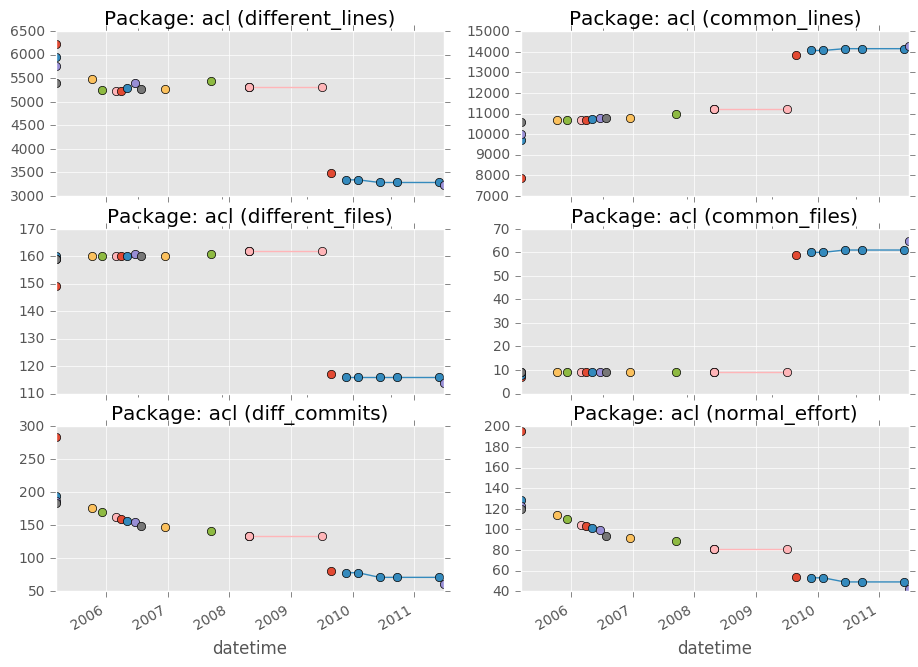

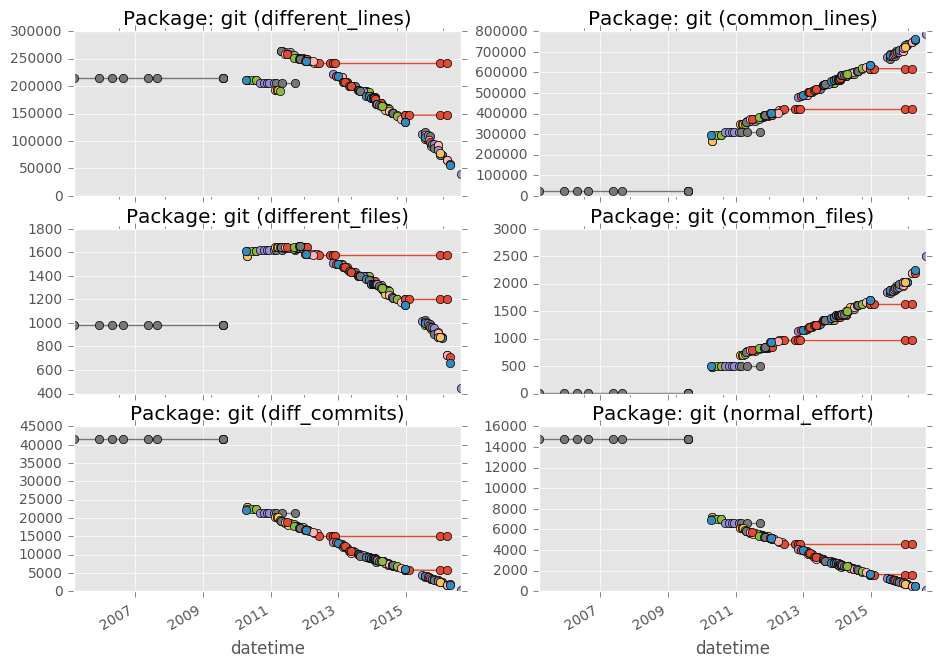

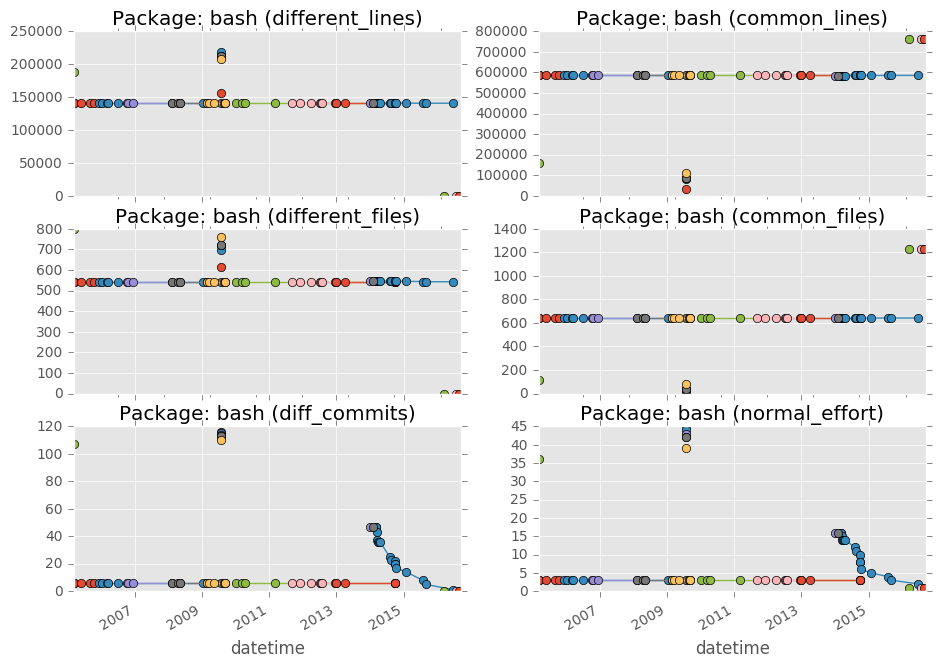

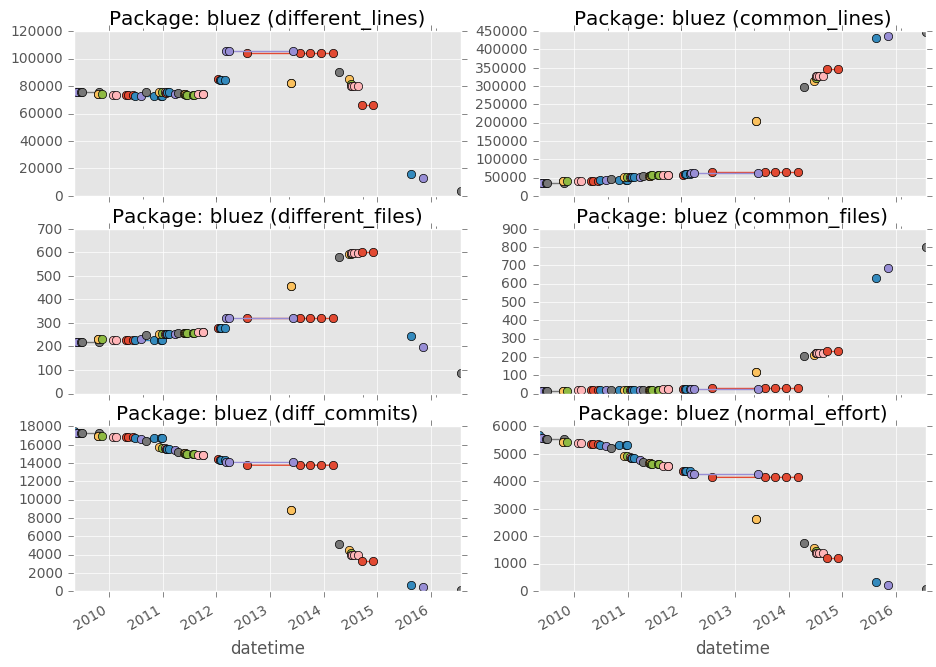

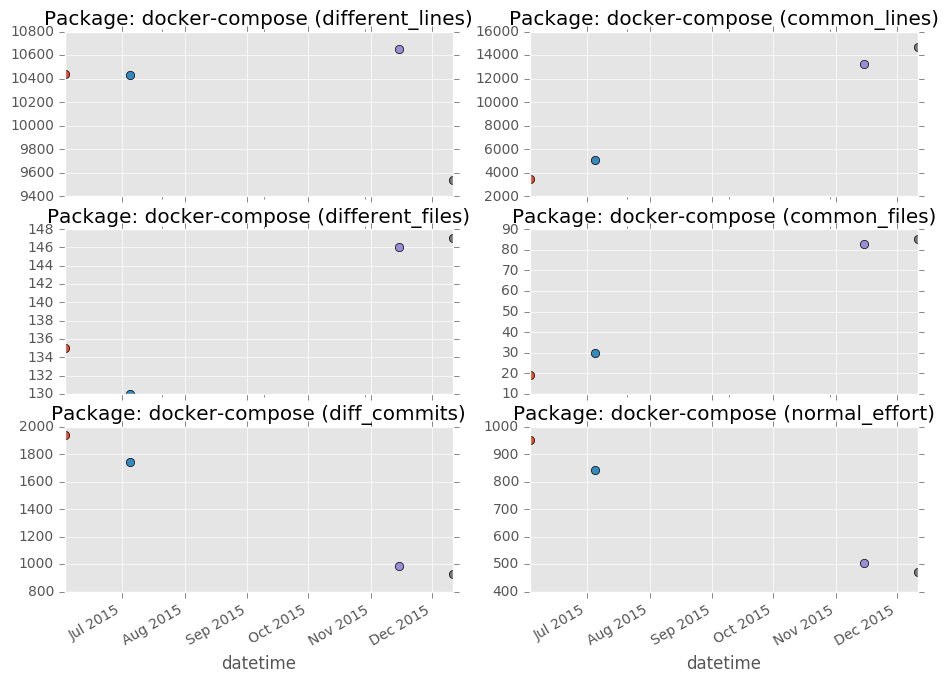

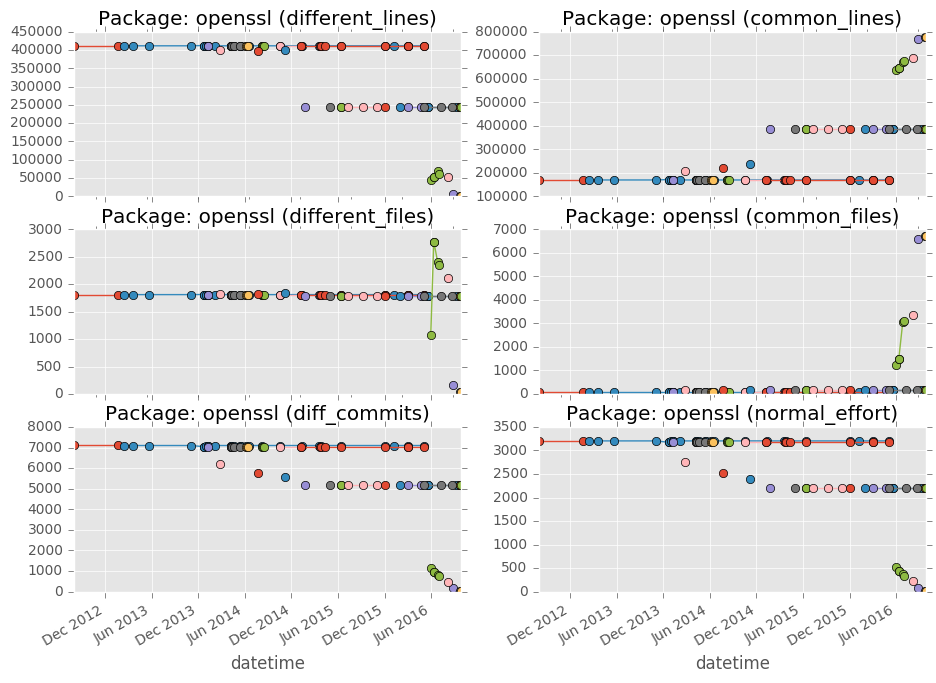

In [142]:
def create_subplots(parameters):
    """Create subplots for each parameter
    
    :param parameters: list of parameters
    :return:           dictionary, with parameters as keys, subplots as values
    
    """
    
    (fig, axes) = plt.subplots((len(parameters)+1)//2, 2, figsize=(11, 8));
    current_ax = [0,0]
    params_ax = {}
    for parameter in parameters:
        params_ax[parameter] = axes[current_ax[0]][current_ax[1]]
        if current_ax[1] == 0:
            current_ax[1] = 1
        else:
            current_ax[0] += 1
            current_ax[1] = 0
    return params_ax

for name in pkgs:
#for name in ['acl']:
    df_pkg = pkgs[name]
    df_pkg = df_pkg.sort_values(by=['epoch', 'upstream', 'revision'])
    df_pkg_metrics = df_pkg[['datetime', 'upstream'] + parameters]
    upstreams = df_pkg['upstream'].unique()
    #print(upstreams)
    params_ax = create_subplots(parameters)
    for upstream in upstreams:
        df_plot = df_pkg_metrics[df_pkg_metrics['upstream'] == upstream]
        for parameter in parameters:
            df_plot.plot(x='datetime', y=parameter, legend=False, sharex=True,
                         kind='line', title='Package: {} ({})'.format(name, parameter),
                         ax=params_ax[parameter], marker='o')